In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
# Downloading stock data
start = '2013-01-01'
end = '2023-11-17'
df = yf.download('PNB.NS', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Plotting the stock data with Moving Averages
ma50 = df['Close'].rolling(50).mean()
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

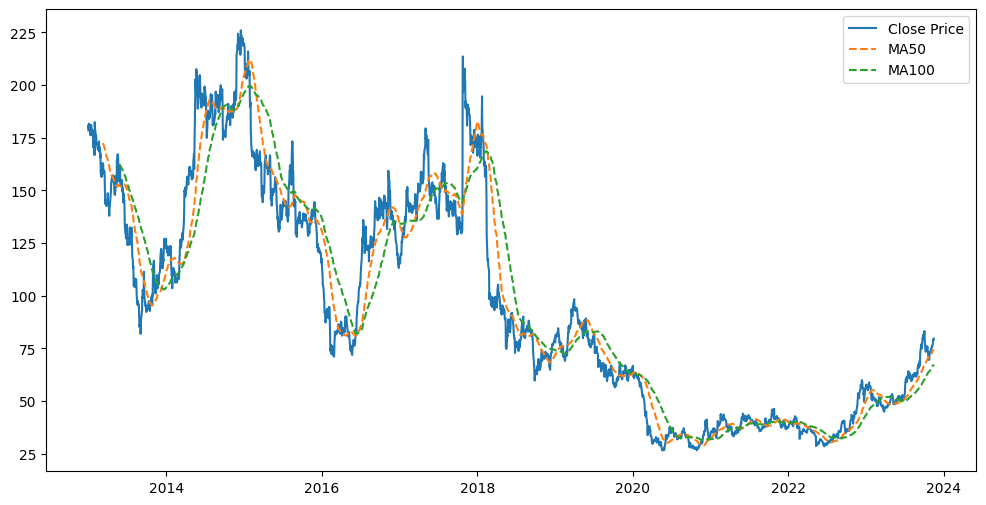

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(ma50, label='MA50', linestyle='dashed')
plt.plot(ma100, label='MA100', linestyle='dashed')
plt.legend()
plt.show()

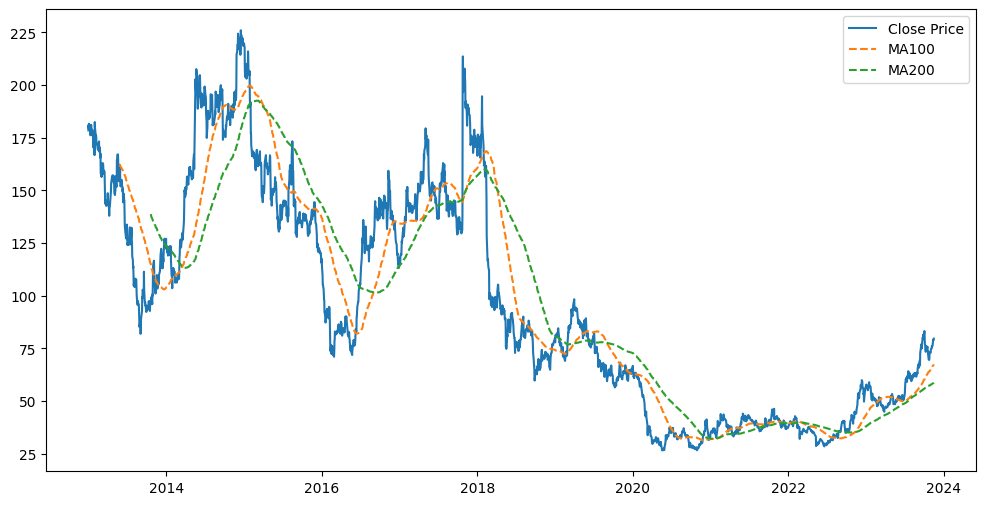

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(ma100, label='MA100', linestyle='dashed')
plt.plot(ma200, label='MA200', linestyle='dashed')
plt.legend()
plt.show()

In [6]:
# Splitting data into training and testing
data_training = pd.DataFrame(df['Close'][0:int(len(df) * 0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df) * 0.7):])

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))

data_training_array = scaler.fit_transform(np.array(data_training).reshape(-1, 1))

In [8]:
step_size = 100

x_train, y_train = [], []

for i in range(step_size, data_training_array.shape[0]):
    x_train.append(data_training_array[i - step_size:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
# Reshape input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
x_train.shape

(1778, 100, 1)

In [11]:
y_train.shape

(1778,)

In [12]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# Build the LSTM model with 5 layers and 64 units
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
hist=model.fit(x_train, y_train, epochs=50)

Epoch 1/50
56/56 [==============================] - 33s 295ms/step - loss: 0.0250
Epoch 2/50
56/56 [==============================] - 17s 301ms/step - loss: 0.0075
Epoch 3/50
56/56 [==============================] - 17s 296ms/step - loss: 0.0065
Epoch 4/50
56/56 [==============================] - 17s 300ms/step - loss: 0.0056
Epoch 5/50
56/56 [==============================] - 17s 302ms/step - loss: 0.0052
Epoch 6/50
56/56 [==============================] - 16s 292ms/step - loss: 0.0053
Epoch 7/50
56/56 [==============================] - 17s 313ms/step - loss: 0.0044
Epoch 8/50
56/56 [==============================] - 17s 305ms/step - loss: 0.0042
Epoch 9/50
56/56 [==============================] - 16s 294ms/step - loss: 0.0052
Epoch 10/50
56/56 [==============================] - 16s 291ms/step - loss: 0.0040
Epoch 11/50
56/56 [==============================] - 16s 292ms/step - loss: 0.0039
Epoch 12/50
56/56 [==============================] - 17s 298ms/step - loss: 0.0037
Epoch 13/50
5

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           3

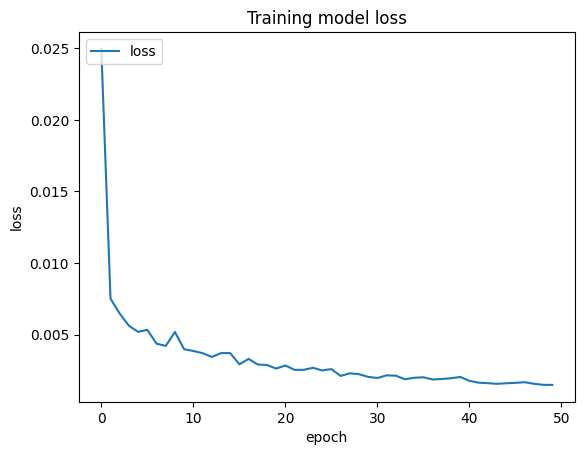

In [15]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['loss'], loc= 'upper left')
plt.show()

In [16]:
model.save('LSTM_unit_64.h5')

C:\Users\suyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Prepare testing data
data = df['Close']
inputs = data[len(data) - len(data_testing) - step_size:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.fit_transform(inputs)

In [18]:
x_test, y_test = [], []

for i in range(step_size, len(inputs)):
    x_test.append(inputs[i - step_size:i])
    y_test.append(inputs[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape input data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Make predictions
y_predicted = model.predict(x_test)
y_predicted_rescaled = scaler.inverse_transform(y_predicted.reshape(-1, 1))
y_test_rescaled = data_testing.values.reshape(-1, 1)

26/26 [==============================] - 8s 109ms/step


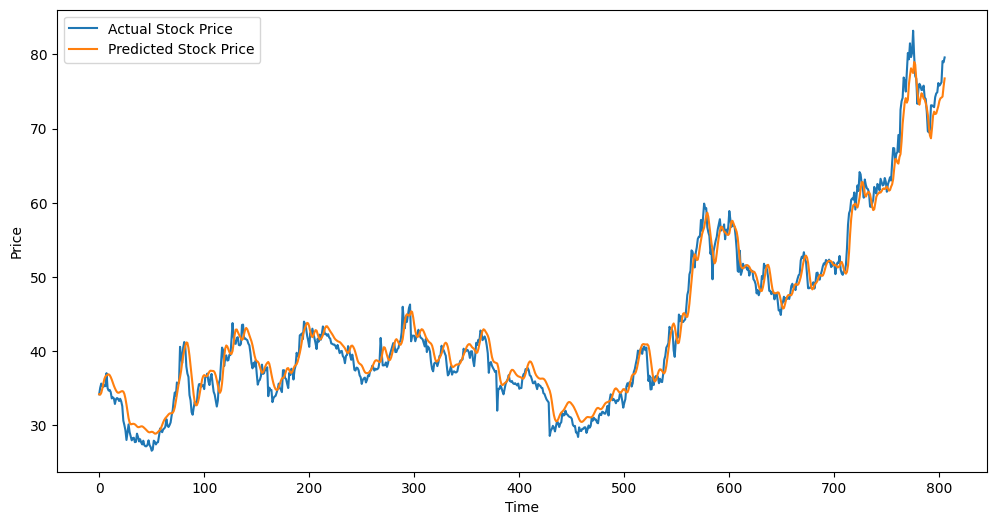

In [20]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Stock Price')
plt.plot(y_predicted_rescaled, label='Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Evaluate the model
r2 = r2_score(y_test_rescaled, y_predicted_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_predicted_rescaled)
mse = mean_squared_error(y_test_rescaled, y_predicted_rescaled)

print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

R^2 Score: 0.9769128499316517
Mean Absolute Error (MAE): 1.409878434969237
Mean Squared Error (MSE): 3.230476331494772


In [22]:
# Prepare input data for prediction
last_days = df['Close'].values[-step_size:]
last_days_scaled = scaler.transform(last_days.reshape(-1, 1))

# Reshape input data to match the model's input shape
input_data = last_days_scaled.reshape((1, step_size, 1))

# Make prediction
predicted_scaled = model.predict(input_data)

# Inverse transform to get the predicted stock price
predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

print("Predicted Stock Price for the Next Day:", predicted_stock_price[0, 0])

1/1 [==============================] - 0s 85ms/step
Predicted Stock Price for the Next Day: 77.28224


In [23]:
# Assuming your model is already trained and loaded
# Assuming you have a variable named 'step_size' for your window size

# Prepare input data for prediction
last_step_days = df['Close'].values[-step_size:]  # Take the last 'step_size' days
last_step_days_scaled = scaler.transform(last_step_days.reshape(-1, 1))

# Reshape input data to match the model's input shape
input_data = last_step_days_scaled.reshape((1, step_size, 1))

# Number of days to predict into the future
num_days_to_predict = 10

# Make predictions for the next 'num_days_to_predict' days
predicted_stock_prices = []

for _ in range(num_days_to_predict):
    # Make prediction
    predicted_scaled = model.predict(input_data)

    # Inverse transform to get the predicted stock price
    predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

    # Append the predicted stock price to the list
    predicted_stock_prices.append(predicted_stock_price[0, 0])

    # Update input_data for the next prediction
    input_data = np.roll(input_data, -1, axis=1)  # Shift the existing data to make room for the new prediction
    input_data[0, -1, 0] = predicted_scaled[0, 0]  # Add the new prediction to the input_data

1/1 [==============================] - 0s 78ms/step


In [24]:
print("Predicted Stock Prices for the Next", num_days_to_predict, "Days:", predicted_stock_prices)

Predicted Stock Prices for the Next 10 Days: [77.28224, 76.33103, 75.06357, 73.978485, 73.14224, 72.499725, 71.98418, 71.53526, 71.10398, 70.65899]


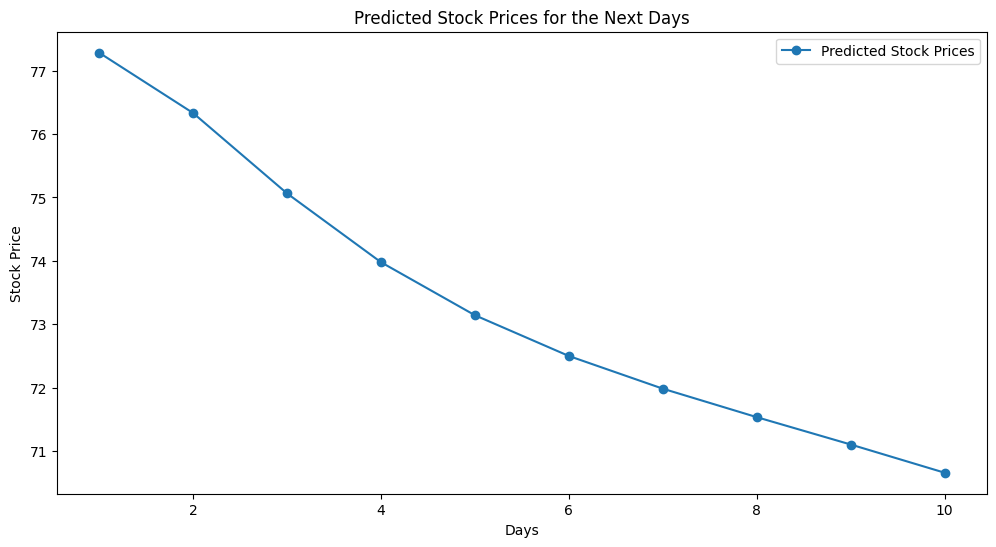

In [25]:
# Create an index for counting
predicted_index = np.arange(1, num_days_to_predict+1)

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(predicted_index, predicted_stock_prices, label='Predicted Stock Prices', marker='o')
plt.title('Predicted Stock Prices for the Next Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()